# Preanalysis
## Xiaonan Wang
## 25/07/2017

10 Samples in total:
    - A1: PBMC-1
    - A2: T-cells-1 (removed for further analysis)
    - A4: PBMC-2
    - B4: PBMC-3
    - C4: T-cells-1
    - D4: T-cells-2
    - E4: T-cells-3
    - F4: stimulated T-cells-1
    - G4: Stimulated T-cells-2
    - H4: Stimulated T-cells-3

Types:
    - P: PBMC
    - D: Donor
    - T: T-cell
    - S: Stimulated

3 Donors:
    - D1P->D1T->D1S
    - D2P->D2T->D2S
    - D3T->D3T->D3S

In [1]:
# import modules, define some functions for loading, saving and processing a gene-barcode matrix
%matplotlib inline
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import tables

np.random.seed(0)

GeneBCMatrix = collections.namedtuple('GeneBCMatrix', ['gene_ids', 'gene_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename, genome):
    with tables.open_file(filename, 'r') as f:
        try:
            dsets = {}
            for node in f.walk_nodes('/' + genome, 'Array'):
                dsets[node.name] = node.read()
            matrix = sp_sparse.csc_matrix((dsets['data'], dsets['indices'], dsets['indptr']), shape=dsets['shape'])
            return GeneBCMatrix(dsets['genes'], dsets['gene_names'], dsets['barcodes'], matrix)
        except tables.NoSuchNodeError:
            raise Exception("Genome %s does not exist in this file." % genome)
        except KeyError:
            raise Exception("File is missing one or more required datasets.")

def save_matrix_to_h5(gbm, filename, genome):
    flt = tables.Filters(complevel=1)
    with tables.open_file(filename, 'w', filters=flt) as f:
        try:
            group = f.create_group(f.root, genome)
            f.create_carray(group, 'genes', obj=gbm.gene_ids)
            f.create_carray(group, 'gene_names', obj=gbm.gene_names)
            f.create_carray(group, 'barcodes', obj=gbm.barcodes)
            f.create_carray(group, 'data', obj=gbm.matrix.data)
            f.create_carray(group, 'indices', obj=gbm.matrix.indices)
            f.create_carray(group, 'indptr', obj=gbm.matrix.indptr)
            f.create_carray(group, 'shape', obj=gbm.matrix.shape)
        except:
            raise Exception("Failed to write H5 file.")
        
def subsample_matrix(gbm, barcode_indices):
    return GeneBCMatrix(gbm.gene_ids, gbm.gene_names, gbm.barcodes[barcode_indices], gbm.matrix[:, barcode_indices])

def get_expression(gbm, gene_name):
    gene_indices = np.where(gbm.gene_names == gene_name)[0]
    if len(gene_indices) == 0:
        raise Exception("%s was not found in list of gene names." % gene_name)
    return gbm.matrix[gene_indices[0], :].toarray().squeeze()


In [3]:
h5_loc = "/servers/lila-single-cell/Xiaonan/Fernando_TenX_SLX_11472_SLX_12473/SLX_12473_combined/fastq/"
h5_fn = ["olds1", "olds2","A4", "B4", "C4", "D4", "E4", "F4", "G4", "H4"]

In [12]:
a = get_matrix_from_h5(h5_loc+'B4'+'_novec_EC10k/outs/filtered_gene_bc_matrices_h5.h5', 'hg19')

In [13]:
print(a.gene_names)
print(a.gene_ids)

['MIR1302-10' 'FAM138A' 'OR4F5' ..., 'CU459201.1' 'AC002321.2' 'AC002321.1']
['ENSG00000243485' 'ENSG00000237613' 'ENSG00000186092' ...,
 'ENSG00000251180' 'ENSG00000215616' 'ENSG00000215611']


Now check which cells have been infected with MP22668 vector.

In [16]:
genome = "hg19_MP22668_IFNB1_5LTR"
mp_cnt_array = [] # for ggplot
mp_cells = {}
mp_counts = {}
for f in sorted(h5_fn):
    mtx = get_matrix_from_h5(h5_loc+f+'_withvec_EC10k/outs/filtered_gene_bc_matrices_h5.h5', genome)
    mp_exp = get_expression(mtx, "IFNB1-5LTR")
    if f == "olds1":
        f = "A1"
    if f == "olds2":
        f = "A2"
    sample_df = pd.DataFrame(data = [mp_exp,[f]*len(mp_exp)], index = ['value','key']).transpose()
    #print("Number of NAs: " + str(sample_df['value'].isnull().sum()))
    per_zero = float((sample_df['value']!=0).sum())*100/sample_df.shape[0]
    print("Percentage of vector infection for " + str(f) + " is " + str("%.2f" % round(per_zero,2)) + "%")
    mp_cnt_array.append(sample_df)
    mp_cells[f] = mtx.barcodes[mp_exp!=0]
    mp_counts[f] = mp_exp[mp_exp!=0]

Percentage of vector infection for A4 is 0.03%
Percentage of vector infection for B4 is 0.04%
Percentage of vector infection for C4 is 32.19%
Percentage of vector infection for D4 is 19.71%
Percentage of vector infection for E4 is 25.65%
Percentage of vector infection for F4 is 24.11%
Percentage of vector infection for G4 is 14.60%
Percentage of vector infection for H4 is 26.12%
Percentage of vector infection for A1 is 0.22%
Percentage of vector infection for A2 is 47.20%


Make pandas data frame for plotting.

In [4]:
# prepare data frame for plotting
mp_cnt_df = pd.concat(mp_cnt_array) 
print(mp_cnt_df.shape)
mp_cnt_df_nonzero = mp_cnt_df[mp_cnt_df['value']!=0]
print(mp_cnt_df_nonzero.shape)
#mp_cnt_df_nonzero.value = mp_cnt_df_nonzero.value.astype(float)
#print("Number of NAs: " + str(mp_cnt_df_nonzero['value'].isnull().sum()))
#print(mp_cnt_df_nonzero.head())
print(mp_cnt_df_nonzero['key'].unique())

(62127, 2)
(11668, 2)
['A4' 'B4' 'C4' 'D4' 'E4' 'F4' 'G4' 'H4' 'A1' 'A2']


/home/USSR/xw251/anaconda2/envs/mypython2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


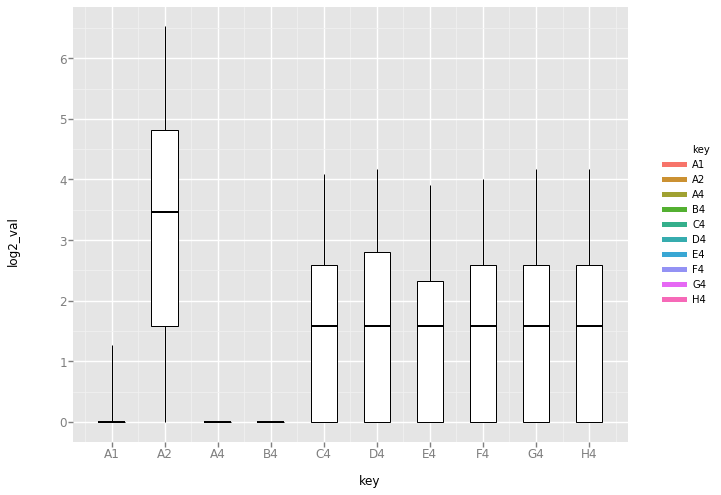

<ggplot: (8770915346577)>

In [8]:
from ggplot import *
mp_cnt_df_nonzero['log2_val'] = np.log2(mp_cnt_df_nonzero['value'].astype('float'))
ggplot(aes(x='key', y='log2_val', fill='key'), data=mp_cnt_df_nonzero)+ geom_boxplot(outliers=False) 

Next to save data frames for further analysis using scanpy.

In [58]:
PBMC_sample = np.array([], dtype=np.int64).reshape(0,32738)
Tcells_sample = np.array([], dtype=np.int64).reshape(0,32738)
PBMC_colnames = np.array([])
Tcells_colnames = np.array([])
keys_PBMC = np.array([])
mp_PBMC = np.array([])
keys_Tcells = np.array([])
mp_Tcells = np.array([])

for f in sorted(h5_fn):
    print(f)
    mtx = get_matrix_from_h5(h5_loc+f+'_novec_EC10k/outs/filtered_gene_bc_matrices_h5.h5', genome_real)
    if f == "olds1":
        f = "A1"
    if f == "olds2":
        f = "A2"
    print(mtx.matrix.transpose().shape)
    if np.in1d(f, DP):
        PBMC_sample= np.concatenate([PBMC_sample, mtx.matrix.toarray().transpose()])
        #print(PBMC_sample.shape)
        for bc in mtx.barcodes:
            if np.in1d(bc, mp_cells[f]):
                idx = np.where(mp_cells[f] == bc)[0]
                mp_PBMC = np.concatenate([mp_PBMC, mp_counts[f][idx]])
            else:
                mp_PBMC = np.concatenate([mp_PBMC, [0]])
        keys_PBMC = np.concatenate([keys_PBMC, [f]*len(mtx.barcodes)])
        PBMC_colnames = np.concatenate([PBMC_colnames, [str(f)+'_'+ str(x) for x in mtx.barcodes]])
    else:
        Tcells_sample= np.concatenate([Tcells_sample, mtx.matrix.toarray().transpose()])
        #print(Tcells_sample.shape)
        for bc in mtx.barcodes:
            if np.in1d(bc, mp_cells[f]):
                idx = np.where(mp_cells[f] == bc)[0]
                mp_Tcells = np.concatenate([mp_Tcells, mp_counts[f][idx]])
            else:
                mp_Tcells = np.concatenate([mp_Tcells, [0]])
        keys_Tcells = np.concatenate([keys_Tcells, [f]*len(mtx.barcodes)])
        Tcells_colnames = np.concatenate([Tcells_colnames, [str(f)+'_'+ str(x) for x in mtx.barcodes]])
print(PBMC_sample.shape)
print(Tcells_sample.shape)
print(keys_PBMC.shape)
print(mp_PBMC.shape)
print(keys_Tcells.shape)
print(mp_Tcells.shape)

A4
(6015, 32738)
B4
(5551, 32738)
C4
(5854, 32738)
D4
(6148, 32738)
E4
(6879, 32738)
F4
(7222, 32738)
G4
(7363, 32738)
H4
(7091, 32738)
olds1
(5553, 32738)
olds2
(4521, 32738)
(17119, 32738)
(45078, 32738)
(17119,)
(17119,)
(45078,)
(45078,)


In [59]:
np.savetxt("PBMC_key_labels.txt", keys_PBMC, delimiter="\t",  fmt="%s")
np.savetxt("PBMC_mp_labels.txt", mp_PBMC, delimiter="\t", fmt="%5i")
np.savetxt("Tcells_key_labels.txt", keys_Tcells, delimiter="\t",  fmt="%s")
np.savetxt("Tcells_mp_labels.txt", mp_Tcells, delimiter="\t", fmt="%5i")
np.savetxt("PBMC_colnames.txt", PBMC_colnames, delimiter="\t",  fmt="%s")
np.savetxt("Tcells_colnames.txt", Tcells_colnames, delimiter="\t", fmt="%s")

In [53]:
%%time
np.savetxt("PBMC_cnt.txt", PBMC_sample, delimiter="\t")

CPU times: user 5min 26s, sys: 17.8 s, total: 5min 44s
Wall time: 5min 50s


In [54]:
%%time
np.savetxt("Tcells_cnt.txt", Tcells_sample, delimiter="\t")

CPU times: user 14min 30s, sys: 50.6 s, total: 15min 21s
Wall time: 15min 32s


### Doublet removal

In [4]:
from doublet_detector import *

In [5]:
genome_real = "hg19"
PBMC_Dlet_score = []
Tcells_Dlet_score = []
for f in sorted(h5_fn):
    print(f)
    mtx = get_matrix_from_h5(h5_loc+f+'_novec_EC10k/outs/filtered_gene_bc_matrices_h5.h5', genome_real)
    if f == "olds1":
        f = "A1"
    if f == "olds2":
        f = "A2"
    mtx_only = mtx.matrix.toarray().transpose()
    Dlet = detect_doublets(mtx_only)
    if np.in1d(f, DP):
        PBMC_Dlet_score.append(Dlet[0])
    else:
        Tcells_Dlet_score.append(Dlet[0])

A4
Total count normalizing
Finding highly variable genes
Using 1884 genes for PCA
Simulating doublets
Running KNN classifier with k = 120
Done
B4
Total count normalizing
Finding highly variable genes
Using 1977 genes for PCA
Simulating doublets
Running KNN classifier with k = 120
Done
C4
Total count normalizing
Finding highly variable genes
Using 2467 genes for PCA
Simulating doublets
Running KNN classifier with k = 120
Done
D4
Total count normalizing
Finding highly variable genes
Using 2554 genes for PCA
Simulating doublets
Running KNN classifier with k = 120
Done
E4
Total count normalizing
Finding highly variable genes
Using 1998 genes for PCA
Simulating doublets
Running KNN classifier with k = 120
Done
F4
Total count normalizing
Finding highly variable genes
Using 2084 genes for PCA
Simulating doublets
Running KNN classifier with k = 120
Done
G4
Total count normalizing
Finding highly variable genes
Using 2133 genes for PCA
Simulating doublets
Running KNN classifier with k = 120
Done

In [7]:
print(len(np.hstack(PBMC_Dlet_score)))
np.savetxt("PBMC_doublet_score.txt", np.hstack(PBMC_Dlet_score), delimiter="\t")
print(len(np.hstack(Tcells_Dlet_score)))
np.savetxt("Tcells_doublet_score.txt", np.hstack(Tcells_Dlet_score), delimiter="\t")

17119
45078
